# European Soccer

## Extracting Data
dataset available at: https://www.kaggle.com/hugomathien/soccer/data

In [1]:
import csv
import sqlite3 as lite

In [2]:
import pandas as pd
import numpy as np

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
con = lite.connect('database.sqlite')

team_df = pd.read_sql_query("SELECT * from Team", con)

In [4]:
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [5]:
team_names = team_df.set_index('team_api_id')['team_long_name'].to_dict()

## Ligue 1 conforama

In [6]:
df = pd.read_csv('ligue1_conforama.csv')

In [7]:
df.head()

,id,id.1,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,4769,4769,4769,4769,2008/2009,1,2008-08-09 00:00:00,483129,8583,9830,...,3.8,2.0,2.9,3.75,2.10,3.00,3.75,2.00,2.88,3.75
1,4770,4770,4769,4769,2008/2009,1,2008-08-09 00:00:00,483130,9827,7819,...,7.5,1.6,3.3,5.50,1.57,3.60,6.00,1.50,3.50,6.50
2,4771,4771,4769,4769,2008/2009,1,2008-08-09 00:00:00,483131,9746,9831,...,3.1,2.3,2.9,3.00,2.35,2.90,3.20,2.38,2.88,2.88
3,4772,4772,4769,4769,2008/2009,1,2008-08-09 00:00:00,483132,8682,8689,...,4.0,2.0,2.9,3.75,2.00,3.10,3.75,1.91,3.00,4.00
4,4773,4773,4769,4769,2008/2009,1,2008-08-10 00:00:00,483133,9748,9941,...,12.0,1.3,4.0,10.00,1.36,4.25,9.00,1.30,4.33,9.00


### On mesure la probabilité empirique pour l'équipe qui accueille de V/N/D

In [8]:
df['goal_diff'] = df['home_team_goal'] - df['away_team_goal']

In [49]:
#goal diff to result
def dtr(delta):
    if delta > 0:
        return 'V'
    elif delta == 0:
        return 'N'
    else:
        return 'D'

In [10]:
df['home_team_result'] = df['goal_diff'].map(delta_to_result)

In [11]:
df['home_team_result'].head()

0    V
1    V
2    V
3    D
4    V
Name: home_team_result, dtype: object

In [17]:
df.groupby('home_team_result').count().reset_index()[['home_team_result', 'id']]

,home_team_result,id
0,D,822
1,N,859
2,V,1359


In [18]:
pV = 1359. / len(df.index)
pN = 859. / len(df.index)
pD = 822. / len(df.index)

In [19]:
# empiric probas of V/N/D for the home_team
p = np.array([pV, pN, pD])
p

array([ 0.44703947,  0.28256579,  0.27039474])

## On aggrège les résultats de la première saison

In [20]:
prev_season = df[df['season'] == '2008/2009']

In [21]:
home_avg = prev_season[['home_team_api_id', 'home_team_goal']].groupby('home_team_api_id').mean().reset_index()

In [22]:
away_avg = prev_season[['away_team_api_id', 'away_team_goal']].groupby('away_team_api_id').mean().reset_index()

In [23]:
prev_teams = prev_season['home_team_api_id'].drop_duplicates().tolist()

In [24]:
home_avg.head()

,home_team_api_id,home_team_goal
0,7819,1.157895
1,8481,1.000000
2,8583,0.947368
3,8592,1.842105
4,8639,1.789474


In [25]:
sum(home_avg[home_avg['home_team_api_id']==7819]['home_team_goal'])

1.1578947368421053

### On construit le graph

In [26]:
import networkx as nx

In [27]:
season = df[df['season'] == '2009/2010']

In [28]:
teams = season['home_team_api_id'].drop_duplicates().tolist()

In [32]:
teams

[8583,
 9827,
 9855,
 8682,
 8639,
 9829,
 10249,
 9851,
 9853,
 9873,
 4170,
 8588,
 8592,
 9831,
 9874,
 8689,
 9748,
 8481,
 9847,
 9941]

In [137]:
dum_hg = np.zeros(38)
dum_ag = np.zeros(38)

for row in season[season['home_team_api_id'] == 8583][['stage','home_team_goal']].iterrows():
    row = row[1]
    dum_hg[row[0]-1] = row[1]
    
for row in season[season['away_team_api_id'] == 8583][['stage','away_team_goal']].iterrows():
    row = row[1]
    dum_ag[row[0]-1] = row[1]

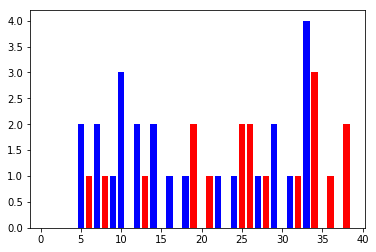

In [142]:
plt.figure()

plt.bar(range(1,39), dum_hg, color = 'b')
plt.bar(range(1,39), dum_ag, color = 'r')

plt.show()

In [29]:
g = nx.DiGraph()

In [30]:
for team_id in teams:
    g.add_node((team_id, 'h'), name = team_names[team_id], ha = 'h')
    g.add_node((team_id, 'a'), name = team_names[team_id], ha = 'a')

In [31]:
for i in teams:
    
    if i in prev_teams:
        for j in teams:
            if i != j:
                wh = sum(home_avg[home_avg['home_team_api_id']==i]['home_team_goal'])
                g.add_edge((i, 'h'), (j, 'a'), weight = wh)

                wa = sum(away_avg[away_avg['away_team_api_id']==i]['away_team_goal'])
                g.add_edge((i, 'a'), (j, 'h'), weight = wa)
            
    else:
        for j in teams:
            if i != j:
                wh = min(home_avg['home_team_goal'])
                g.add_edge((i, 'h'), (j, 'a'), weight = wh)

                wa = min(away_avg['away_team_goal'])
                g.add_edge((i, 'a'), (j, 'h'), weight = wa)

In [90]:
def update_g(g, season, stage, alpha = 0.5):
    for (u,v) in g.edges():
        g[u][v]['weight'] *= alpha
        
    day = season[season['stage']==stage]
    
    for row in day[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].iterrows():
        row = row[1]
        ht_id = row['home_team_api_id']
        at_id = row['away_team_api_id']
        htg = row['home_team_goal']
        atg = row['away_team_goal']

        g[(ht_id, 'h')][(at_id, 'a')]['weight'] += (1 - alpha) * htg
        g[(at_id, 'a')][(ht_id, 'h')]['weight'] += (1 - alpha) * atg
        
    return g

In [46]:
#predicts the result of a match
def pred_m(g, ht_id, at_id, thres = 0.1):
    flow_h = nx.maximum_flow_value(g, (ht_id, 'h'), (at_id, 'a'), capacity = 'weight')
    flow_a = nx.maximum_flow_value(g, (at_id, 'a'), (ht_id, 'h'), capacity = 'weight')
    
    delta = flow_h - flow_a
    
    if delta > thres:
        res = 'V'
    elif delta < -thres:
        res = 'D'
    else:
        res = 'N'
    
    return res, delta

In [60]:
#returns prediction, confidence and true goal diff for each match of a given day
def pred_d(g, day):
    d_pred = []
    for row in day[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].iterrows():
        row = row[1]
        ht_id = row['home_team_api_id']
        at_id = row['away_team_api_id']
        htg = row['home_team_goal']
        atg = row['away_team_goal']
        
        m_pred, delta = pred_m(g, ht_id, at_id)
        d_pred.append([ht_id, at_id, m_pred, delta, htg-atg])
        
    return d_pred

In [108]:
def pred_s(g, season):
    predictions = []
    for stage in range(1,39):
        day = season[season['stage']==stage]

        predictions.append(pred_d(g, day))

        g = update_g(g, season, stage, alpha = 0.75)
        
    return predictions

In [109]:
preds = pred_s(g, season)

In [110]:
dflows = [d[m][3] for d in preds for m in range(len(d))]

In [94]:
(abs(np.array(dflows)) < 0.01).sum() / len(dflows)

0.039473684210526314

In [95]:
gdiff = [d[m][-1] for d in preds for m in range(len(d))]

In [111]:
vcts = [flow for i, flow in enumerate(dflows) if gdiff[i] > 0]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   1.,   3.,   5.,   1.,   3.,   0.,   9.,
          0.,  11.,  15.,   6.,  14.,  20.,  13.,  11.,  14.,  11.,  14.,
         10.,   9.,   0.,   2.,   2.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

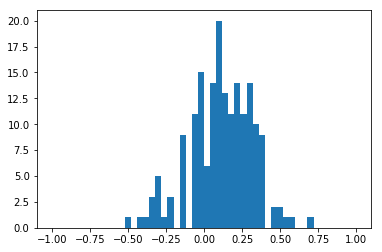

In [112]:
plt.hist(vcts, bins = 50, range = (-1,1))

In [113]:
dfts = [flow for i, flow in enumerate(dflows) if gdiff[i] < 0]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   2.,   1.,   1.,   3.,   2.,   2.,   6.,   6.,
          8.,   7.,   7.,   6.,  14.,   5.,   5.,   5.,   7.,   3.,   3.,
          2.,   2.,   1.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

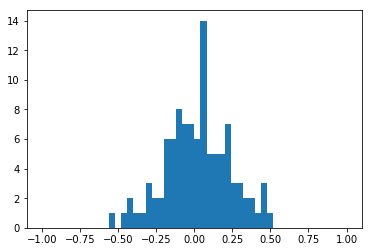

In [114]:
plt.hist(dfts, bins = 50, range = (-1,1))

In [107]:
(np.array(gdiff) > 0).sum() 

179

In [126]:
(np.array(dfts) < -0.16).sum()

19

In [125]:
(np.array(vcts) >= -0.16).sum()

164

In [127]:
(19 + 164) / 380

0.48157894736842105

In [100]:
nuls = [flow for i, flow in enumerate(dflows) if gdiff[i] == 0]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  3.,  3.,  1.,  1.,  8.,  3.,  7.,
         7.,  5.,  8.,  9.,  5.,  4.,  3.,  5.,  5.,  6.,  2.,  2.,  1.,
         3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

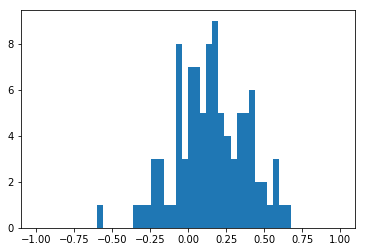

In [101]:
plt.hist(nuls, bins = 50, range = (-1,1))

In [133]:
pr = nx.pagerank(g, alpha=0.7)

In [135]:
spr = sorted([((team_names[key[0]], key[1]), value) for key, value in pr.items()], key = lambda x: x[1])

In [138]:
scores = {}
for ((team, ha), pr) in spr:
    if team in scores:
        scores[team] += pr
    else:
        scores[team] = pr

In [140]:
sorted([(key, value) for key, value in scores.items()], key = lambda x: x[1]) 

[('Toulouse FC', 0.023625509736124959),
 ("US Boulogne Cote D'Opale", 0.029820104575955624),
 ('Olympique Lyonnais', 0.033323692289347499),
 ('Le Mans FC', 0.037792703007271014),
 ('AS Monaco', 0.038609723257016434),
 ('Olympique de Marseille', 0.038934731142824835),
 ('Grenoble Foot 38', 0.040753128341530886),
 ('Paris Saint-Germain', 0.046458384406384889),
 ('LOSC Lille', 0.047694811892405653),
 ('Valenciennes FC', 0.051481061921394886),
 ('Stade Rennais FC', 0.051612293400432586),
 ('FC Sochaux-Montbéliard', 0.05353634904798827),
 ('AS Saint-Étienne', 0.054220800109112781),
 ('AJ Auxerre', 0.055611240408380447),
 ('OGC Nice', 0.056039812085183036),
 ('Girondins de Bordeaux', 0.057462729615491905),
 ('Montpellier Hérault SC', 0.060830299379942131),
 ('AS Nancy-Lorraine', 0.062619163627455329),
 ('FC Lorient', 0.074040343231732475),
 ('RC Lens', 0.085533118524024496)]